## Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
from tensorflow.keras.applications import DenseNet201
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils import resample
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
import tensorflow_hub as hub
import sklearn.metrics as m
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

## Data Pre-Processing

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/'

In [ ]:
df = pd.read_csv(base_path + 'datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['img_path'] = base_path + 'datasets/train/images/' + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [ ]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_count = 1200
df_balanced = pd.DataFrame(columns=df.columns)

for label in classes:
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipython-input-10-3466899084.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_balanced = pd.concat([df_balanced, df_class_balanced])


In [ ]:
len(df)

8400

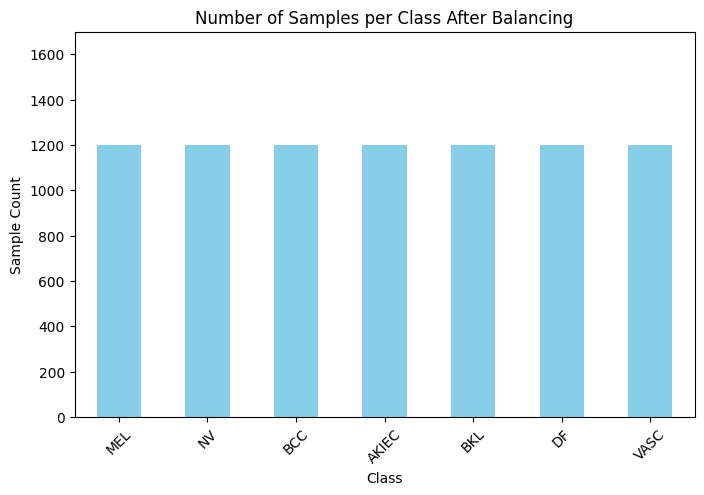

In [ ]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [ ]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training:
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create dataset
df_train = create_dataset(df, training=True)

In [ ]:
df_validate = pd.read_csv(base_path + 'datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = base_path + 'datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv(base_path + 'datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = base_path + 'datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [ ]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [ ]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Vision Transformer (ViT)

In [ ]:
def cnn_branch(inputs):

  base_model = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
    )

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  return x

In [ ]:
def vit_layer(img, num_heads, ff_dim, num_transformer_blocks, dropout_rate):
    # Patch creation
    patch_size = 16
    num_patches = (img.shape[1] // patch_size) ** 2
    projection_dim = ff_dim

    x = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(img)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Positional encoding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + pos_embedding

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        # Layer Norm 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        attention_output = layers.Dropout(dropout_rate)(attention_output)
        x2 = layers.Add()([x, attention_output])

        # Layer Norm 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ff_output = layers.Dense(ff_dim, activation='relu')(x3)
        ff_output = layers.Dense(projection_dim)(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.Add()([x2, ff_output])

    # Global representation
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    return x


In [ ]:
def build_model():
    num_classes = 7

    num_heads = 4
    ff_dim = 512
    num_transformer_blocks = 2
    vit_dropout = 0.5

    inputs = layers.Input(shape=(224, 224, 3))
    cnn_features = cnn_branch(inputs)
    vit_features = vit_layer(inputs, num_heads, ff_dim, num_transformer_blocks, vit_dropout)

    fused = layers.Concatenate()([cnn_features, vit_features])

    x = layers.Dense(1280, activation='relu')(fused)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    learning_rate =  3.01e-05
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model()

In [ ]:
total_params = model.count_params()
print(f"Total Parameters: {total_params:,}")

Total Parameters: 31,954,247


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
start_time = time.time()
hist = model.fit(df_train,epochs=30,validation_data=df_validate,callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom ViT with DN201 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1145s 559ms/step - accuracy: 0.3805 - loss: 1.9104 - val_accuracy: 0.6425 - val_loss: 0.9734 - learning_rate: 3.0100e-05
Epoch 2/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.6478 - loss: 1.0674 - val_accuracy: 0.7358 - val_loss: 0.7574 - learning_rate: 3.0100e-05
Epoch 3/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.7116 - loss: 0.8684 - val_accuracy: 0.6632 - val_loss: 1.1725 - learning_rate: 3.0100e-05
Epoch 4/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.7682 - loss: 0.7009 - val_accuracy: 0.7254 - val_loss: 0.8887 - learning_rate: 3.0100e-05
Epoch 5/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.7836 - loss: 0.6366 - val_accuracy: 0.8031 - val_loss: 0.6389 - learning_rate: 3.0100e-05
Epoch 6/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.8204 - loss: 0.5438 - val_accuracy: 0.7461 - val_loss: 0.7678 - learning_rate: 3.0100e-05
Epoch 7/30
1050/1050 ━━━━━━━━━━━

## Model Evaluation

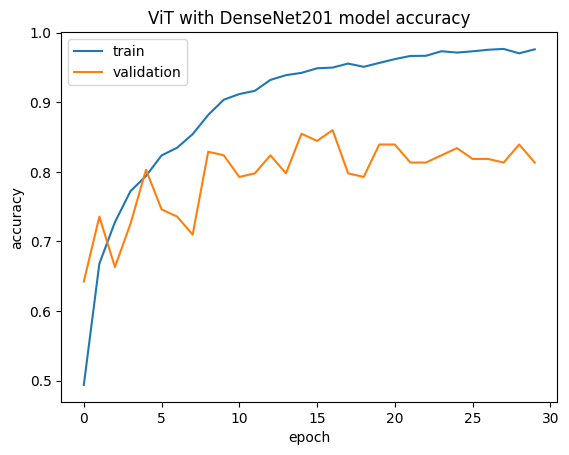

In [ ]:
plot_hist(hist, "ViT with DenseNet201")

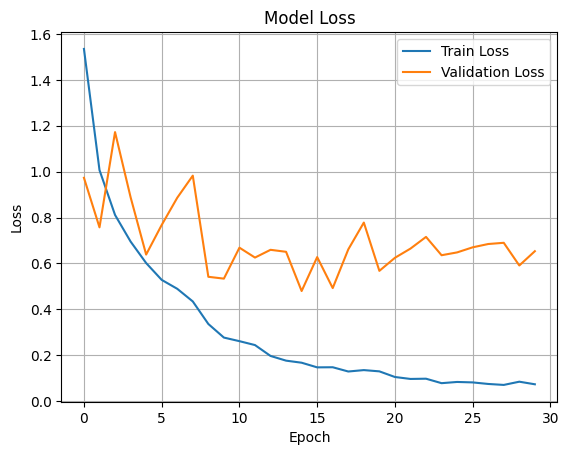

In [ ]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


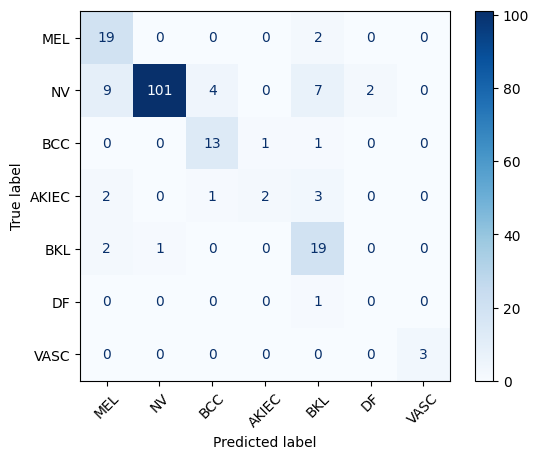

In [ ]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [ ]:
test_loss, *test_metrics = model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 110s 579ms/step - accuracy: 0.8219 - loss: 0.7300
Test Loss: 0.8594934940338135
Test Metrics: [0.7870370149612427]


In [ ]:
model_save_name = 'modelViT_DN201_v2_Final.keras'
path = f"{base_path}saved_models/{model_save_name}"
model.save(path)

In [ ]:
val_preds = model.predict(df_validate)
val_preds_labels = np.argmax(val_preds, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 876ms/step


In [ ]:
val_true_labels = []
for _, labels in df_validate:
    val_true_labels.extend(np.argmax(labels.numpy(), axis=1))
val_true_labels = np.array(val_true_labels)

In [ ]:
test_preds = model.predict(df_test)
test_preds_labels = np.argmax(test_preds, axis=1)

test_true_labels = []
for _, labels in df_test:
    test_true_labels.extend(np.argmax(labels.numpy(), axis=1))
test_true_labels = np.array(test_true_labels)

189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


In [ ]:
# Validation scores
print("Validation Metrics:")
print(m.classification_report(val_true_labels, val_preds_labels, target_names=classes))

# Test scores
print("Test Metrics:")
print(m.classification_report(test_true_labels, test_preds_labels, target_names=classes))

Validation Metrics:
              precision    recall  f1-score   support

         MEL       0.59      0.90      0.72        21
          NV       0.99      0.82      0.90       123
         BCC       0.72      0.87      0.79        15
       AKIEC       0.67      0.25      0.36         8
         BKL       0.58      0.86      0.69        22
          DF       0.00      0.00      0.00         1
        VASC       1.00      1.00      1.00         3

    accuracy                           0.81       193
   macro avg       0.65      0.67      0.64       193
weighted avg       0.86      0.81      0.82       193

Test Metrics:
              precision    recall  f1-score   support

         MEL       0.47      0.75      0.58       171
          NV       0.94      0.82      0.88       909
         BCC       0.77      0.65      0.70        93
       AKIEC       0.61      0.53      0.57        43
         BKL       0.67      0.79      0.73       217
          DF       0.71      0.66      0.68 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

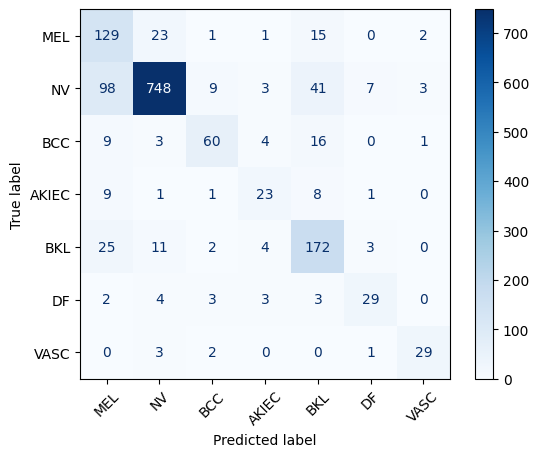

In [ ]:
y_true_test = []
y_pred_test = []

for images, labels in df_test:
    preds = model.predict(images)
    y_true_test.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)